In [677]:
import pandas as pd
import numpy as np
from geopy.distance import distance
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns


<h2 style="color:green"> Tiptrac Project </h2>

- **Les objectifs de l'exercice sont les suivants** :

 ce projet consiste à Extraire des informations intéressantes  telles que le **prix** min, moyen et max, la durée min/max/moyenne par trajet.
  Quantifier les différences de **prix** et de durée moyenne selon le train, le bus et le covoiturage, et selon la   distance du trajet **(0-200km, 201-800km, 800-2000km, 2000+km)**.
  
  
  
  
- ***plan du nootebook *** :

  1- import des données
  
   - jointures pour l'extraction d'informations intéressantes et calcul
   - Helper fonctions  
  
  2- Extraction d'informations générales intéressantes
  
   - Statistiques sur les prix par trajet
   - Statistiques sur les durées par trajet
  
  3-Extraction d'informations selon les distances de trajet
  
   - Calcul des statistiques
   - Visualisation sur les différences de prix
   - Visualisation sur les différences de durée
  
  4- algorithme de prédiction des prix
   - Feature engineering
   - Modelling 
   - Evaluation des Modeles 



# 1- Importer  les dataset  :

In [678]:
# cities
cities = pd.read_csv('/Users/xxx/Downloads/cities.csv', index_col='id')
# providers
providers = pd.read_csv('/Users/xxx/Downloads/providers.csv', index_col='id')
# stations
stations = pd.read_csv('/Users/xxx/Downloads/stations.csv', index_col='id')
# ticket_data
parse_dates = ['departure_ts', 'arrival_ts', 'search_ts'] # colonnes contenant des timestamps
ticket_data = pd.read_csv('/Users/xxx/Downloads/ticket_data.csv', index_col='id', parse_dates=parse_dates)

In [679]:
cities.head(2)

,local_name,unique_name,latitude,longitude,population
id,,,,,
5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0
76,"Barcelona, CataluÃ±a, EspaÃ±a",barcelona,41.385064,2.173404,1611822.0


In [680]:
providers.head(2)

,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
id,,,,,,,,,
9,1,NaN,ouibus,Ouibus,True,True,True,False,bus
10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus


In [681]:
stations.head(2)

,unique_name,latitude,longitude
id,,,
1,Aalen (Stuttgarter StraÃŸe),48.835296,10.092956
2,AÃ©roport Bordeaux-MÃ©rignac,44.830226,-0.700883


In [682]:
ticket_data.head(2)

,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
id,,,,,,,,,,,
6795025,8385,NaN,NaN,2017-10-13 14:00:00+00:00,2017-10-13 20:10:00+00:00,4550,2017-10-01 00:13:31.327000+00:00,NaN,NaN,611,542
6795026,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{149,418}",{13},611,542


In [683]:
# Conversion des prix en euros :
ticket_data['price'] = ticket_data['price_in_cents'] / 100

In [684]:
ticket_data.loc[:,'price']

id
6795025     45.5
6795026     14.5
6795027     74.0
6795028    135.0
6795029     77.1
           ...  
6869182     25.9
6869185     27.0
6869187     30.0
6869189     28.8
6869191     20.0
Name: price, Length: 74168, dtype: float64

In [685]:
# Calcul des durées de trajet et conversion en jour 

ticket_data['travel_time'] = ticket_data.arrival_ts - ticket_data.departure_ts


In [686]:
# Calcul des durées de trajet et convertion en heures 
ticket_data.loc[:,'travel_time_hours']=ticket_data.loc[:,'travel_time'].apply(lambda x:x.days * 24 + x.seconds / 3600)

In [687]:
ticket_data.loc[:,'travel_time_hours']

id
6795025     6.166667
6795026    17.833333
6795027    31.950000
6795028    21.583333
6795029    21.766667
             ...    
6869182    13.500000
6869185     6.500000
6869187     6.750000
6869189     7.750000
6869191     6.916667
Name: travel_time_hours, Length: 74168, dtype: float64

In [688]:
ticket_data.head()

,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,price,travel_time,travel_time_hours
id,,,,,,,,,,,,,,
6795025,8385,NaN,NaN,2017-10-13 14:00:00+00:00,2017-10-13 20:10:00+00:00,4550,2017-10-01 00:13:31.327000+00:00,NaN,NaN,611,542,45.5,0 days 06:10:00,6.166667
6795026,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{149,418}",{13},611,542,14.5,0 days 17:50:00,17.833333
6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{798,798,6794,6246}","{8377,8376}",611,542,74.0,1 days 07:57:00,31.950000
6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{798,798,6794,6246}","{8377,8376}",611,542,135.0,0 days 21:35:00,21.583333
6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,"{5983,5983}",{8380},611,542,77.1,0 days 21:46:00,21.766667


In [689]:
cities.head()

,local_name,unique_name,latitude,longitude,population
id,,,,,
5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0
76,"Barcelona, CataluÃ±a, EspaÃ±a",barcelona,41.385064,2.173404,1611822.0
81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN
259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0
11979,"BalÈ™, Olt, RomÃ¢nia",balÈ™,44.353354,24.095672,NaN


In [690]:
# pour combiner les latitudes et longitude de ville de depart ainsi d'arrivee dans le dataframe ticket_data

ticket_data = pd.merge(ticket_data, cities[['latitude', 'longitude']], how='left', left_on=['o_city'], right_on=['id'])
ticket_data.rename(columns={'latitude': 'o_latitude', 'longitude': 'o_longitude'}, inplace=True)


ticket_data = pd.merge(ticket_data, cities[['latitude', 'longitude']], how='left', left_on=['d_city'], right_on=['id'])
ticket_data.rename(columns={'latitude': 'd_latitude', 'longitude': 'd_longitude'}, inplace=True)

In [691]:
# Importing the geodesic module from the library
from geopy.distance import geodesic
# calcul de distance entre 2 lieux connus par leurs coordonnées GPS (latittude, lonitude)  
def distance_Km (row):
    return geodesic((row['o_latitude'],row['o_longitude']),(row['d_latitude'],row['d_longitude'])).km


In [692]:
ticket_data['distance'] = ticket_data.apply(distance_Km, axis=1)

In [693]:
ticket_data['distance']

0        503.136831
1        503.136831
2        503.136831
3        503.136831
4        503.136831
            ...    
74163    339.046766
74164    339.046766
74165    339.046766
74166    339.046766
74167    339.046766
Name: distance, Length: 74168, dtype: float64

In [694]:
# On regroupe les données de la recherche son depart ainsi son arrive

ticket_data.groupby('search_ts')['o_city', 'd_city'].mean()


<ipython-input-694-7e1671d1dee5>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ticket_data.groupby('search_ts')['o_city', 'd_city'].mean()


,o_city,d_city
search_ts,,
2017-10-01 00:13:31.327000+00:00,611.0,542.0
2017-10-01 00:13:35.773000+00:00,611.0,542.0
2017-10-01 00:13:40.212000+00:00,611.0,542.0
2017-10-01 00:13:40.213000+00:00,611.0,542.0
2017-10-01 01:03:18.948000+00:00,628.0,453.0
...,...,...
2017-10-19 10:35:31.269000+00:00,628.0,562.0
2017-10-19 10:35:40.167000+00:00,628.0,562.0
2017-10-19 10:35:40.168000+00:00,628.0,562.0


# 2- Extraction d'informations générales intéressantes

In [699]:
# type de transport dans notre dataset 

providers.loc[:,'transport_type'].unique().tolist()

['bus', 'car', 'train', 'carpooling']

In [700]:
price_table = pd.merge(ticket_data[['o_city', 'd_city', 'price']], cities[['unique_name']], how='left', left_on='o_city', right_on=['id'])
price_table.rename(columns={'unique_name': 'o_name'}, inplace=True)

price_table = pd.merge(price_table, cities[['unique_name']], how='left', left_on='d_city', right_on=['id'])
price_table.rename(columns={'unique_name': 'd_name'}, inplace=True)

In [701]:
price_table

,o_city,d_city,price,o_name,d_name
0,611,542,45.5,orleans,montpellier
1,611,542,14.5,orleans,montpellier
2,611,542,74.0,orleans,montpellier
3,611,542,135.0,orleans,montpellier
4,611,542,77.1,orleans,montpellier
...,...,...,...,...,...
74163,628,562,25.9,paris,nantes
74164,628,562,27.0,paris,nantes
74165,628,562,30.0,paris,nantes
74166,628,562,28.8,paris,nantes


In [702]:
price_table = price_table.groupby(['o_name', 'd_name']).agg({'price': ['min', 'max', 'mean']})

price_table

price                   
                                            min    max        mean
o_name                d_name                                      
aeroport-paris-vatry- troyes               53.0   53.0   53.000000
agde                  amsterdam           186.0  220.0  203.200000
agen                  dijon                98.6  136.5  117.550000
                      marseille            20.0   89.2   40.426667
                      marseille-aeroport   37.0   40.5   38.333333
...                                         ...    ...         ...
villefranche-sur-cher bordeaux             30.6   76.7   58.850000
vitre                 nice                150.7  219.2  184.950000
zurich                dijon                14.0   24.0   18.725000
                      liege                40.5   41.9   40.966667
                      strasbourg           14.0   17.8   15.900000

[1437 rows x 3 columns]

# 2.1- Travel Time :

In [703]:
# Jointure sur l'id des villes pour récupérer les temps de trajet
durations_table = pd.merge(ticket_data[['o_city', 'd_city', 'travel_time', 'travel_time_hours']], cities[['unique_name']], how='left', left_on='o_city', right_on=['id'])
durations_table.rename(columns={'unique_name': 'o_name'}, inplace=True)



durations_table = pd.merge(durations_table, cities[['unique_name']], how='left', left_on='d_city', right_on=['id'])
durations_table.rename(columns={'unique_name': 'd_name'}, inplace=True)


In [704]:

durations_table.groupby(['o_name', 'd_name'])[['travel_time_hours']].agg(['min', 'max', 'mean'])




travel_time_hours             \
                                                       min        max   
o_name                d_name                                            
aeroport-paris-vatry- troyes                     21.916667  21.916667   
agde                  amsterdam                   8.883333  15.900000   
agen                  dijon                      12.400000  15.016667   
                      marseille                   5.600000  12.333333   
                      marseille-aeroport          5.000000   8.000000   
...                                                    ...        ...   
villefranche-sur-cher bordeaux                    3.166667  37.733333   
vitre                 nice                        9.883333  11.083333   
zurich                dijon                       8.166667  17.750000   
                      liege                       5.833333  11.500000   
                      strasbourg                  4.916667  10.583333   

                                                     
                                               mean  
o_name                d_name                         
aeroport-paris-vatry- troyes              21.916667  
agde                  amsterdam           10.313333  
agen                  dijon               13.708333  
                      marseille            8.290000  
                      marseille-aeroport   5.833333  
...                                             ...  
villefranche-sur-cher bordeaux            11.675000  
vitre                 nice                10.483333  
zurich                dijon               12.958333  
                      liege                7.722222  
                      strasbourg           7.000000  

[1437 rows x 3 columns]

# 3. Extraction d'informations selon les distances de trajet

In [705]:
# Merge des providers dansticket_data
ticket_data = pd.merge(ticket_data, providers[['fullname', 'transport_type']], how='left', left_on=['company'], right_on=['id'])

In [706]:
ticket_data.distance=ticket_data.distance.astype('float64')

In [707]:
# classer les distance dans des intervalles 


ticket_data['classe']=pd.cut(ticket_data.distance,
                             bins=[0,200,800,2000,2001],
                             labels=['0-200km','201-800km','800-2000km','2000+ km'])

In [708]:
ticket_data.groupby(['classe', 'transport_type'])\
.agg({'travel_time': ['min', 'max', pd.Series.mean], 'price' : ['min', 'max', 'mean']})

travel_time                   \
                                      min              max   
classe     transport_type                                    
0-200km    bus            0 days 01:05:00 13 days 05:45:00   
           carpooling     0 days 00:20:00  0 days 17:20:00   
           train          0 days 00:39:00  1 days 10:27:00   
201-800km  bus            0 days 02:29:00 20 days 12:51:00   
           carpooling     0 days 01:20:00  0 days 19:50:00   
           train          0 days 01:08:00  2 days 00:27:00   
800-2000km bus            0 days 12:15:00 14 days 17:00:00   
           carpooling     0 days 07:50:00  1 days 05:10:00   
           train          0 days 03:33:00  1 days 16:37:00   
2000+ km   bus                        NaT              NaT   
           carpooling                 NaT              NaT   
           train                      NaT              NaT   

                                                     price                     
                                               mean    min    max        mean  
classe     transport_type                                                      
0-200km    bus            0 days 10:13:57.053140096   8.50  229.0   21.828309  
           carpooling     0 days 01:57:07.342427561   3.00  128.5   11.773524  
           train          0 days 04:25:09.840098400   4.90  251.0   34.879008  
201-800km  bus            0 days 15:04:29.269314709  10.00  224.8   34.948500  
           carpooling     0 days 04:45:47.272436410   8.50  138.0   32.180643  
           train          0 days 07:40:39.543514566  14.00  385.5   91.247795  
800-2000km bus            1 days 03:32:10.027247956  22.90  174.0   69.499500  
           carpooling     0 days 13:06:00.839160839  44.96  161.5   86.265455  
           train          0 days 12:09:31.021671826  19.40  375.5  154.637461  
2000+ km   bus                                  NaT    NaN    NaN         NaN  
           carpooling                           NaT    NaN    NaN         NaN  
           train                                NaT    NaN    NaN         NaN

/Users/xxx/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


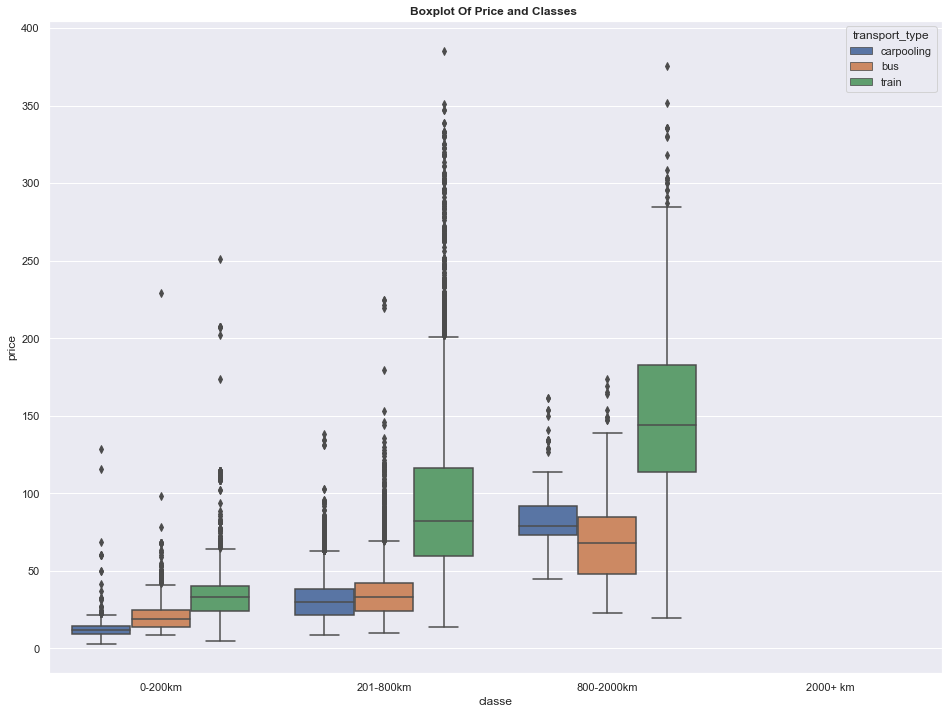

In [709]:
plt.figure(figsize=(16,12))
sns.boxplot('classe','price',hue="transport_type",data=ticket_data)
plt.title("Boxplot Of Price and Classes ",fontweight="bold")
plt.show()

<h2 style="color:green">Commentaires</h2>

On Remarque que:

- plus la distance est grande, plus le prix de trajet est elevé ;

- en dessous de 800 km, les trajets en co-voiturage sont les moins chers, puis le bus et enfin le train;

- au plus de 800 Km, les trajets en bus sont les moins chers puis le co-voiturage et enfin le train .















<Figure size 1152x864 with 0 Axes>

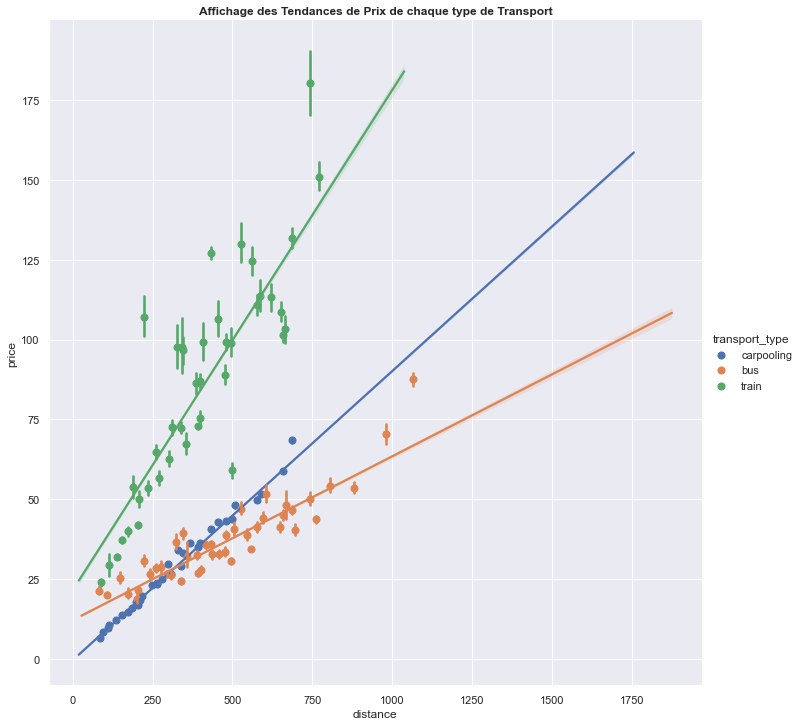

In [710]:


plt.figure(figsize=(16,12))
sns.lmplot(data=ticket_data, x='distance', y='price', hue='transport_type',x_bins=50,height=10)
plt.title('Affichage des Tendances de Prix de chaque type de Transport',fontweight='bold')
plt.show()

In [742]:
ticket_data.transport_type =='bus'

departure_ts
2017-10-13 14:00:00+00:00    False
2017-10-13 13:05:00+00:00     True
2017-10-13 13:27:00+00:00    False
2017-10-13 13:27:00+00:00    False
2017-10-13 21:46:00+00:00    False
                             ...  
2017-10-27 02:30:00+00:00     True
2017-10-27 07:00:00+00:00     True
2017-10-27 08:30:00+00:00     True
2017-10-27 13:25:00+00:00     True
2017-10-27 14:45:00+00:00     True
Name: transport_type, Length: 74168, dtype: bool

 <h2 style="color:green"> Commentaires </h2>

On Remarque que:

- la tendance du prix du trains presente une  tendance croissante rapide (augmente rapidement);


- la tendance du prix du bus presente une  tendance croissante Lente (augmente le moins vite);

- l'intersection des courbes bleue et orange es au 275 Km . ce qui veut dire apres 275 le bus devient moins 
   cher que le co-voiturage

#  4- algorithme de prédiction des prix :

## Feature engineering:

In [711]:
# Calcul du temps restant entre la recherche et le départ
ticket_data['time_before_departure'] = ticket_data.departure_ts - ticket_data.search_ts
ticket_data['time_before_departure_hours'] = ticket_data.apply(timedelta_to_hours, args=['time_before_departure'], axis=1)

In [787]:
ticket_data['days_time_before_departure']=ticket_data['time_before_departure'].apply(lambda x: x.days)




In [796]:
ticket_data['days_time_before_departure'].describe()

count    74168.000000
mean         6.722036
std         10.582113
min        -24.000000
25%          1.000000
50%          4.000000
75%          8.000000
max        176.000000
Name: days_time_before_departure, dtype: float64

In [798]:
sub_data=ticket_data[ticket_data['time_before_departure_hours']>0]


In [838]:
# define classe_day columns qui prend un intervalle de jours 

sub_data['classe_day']=pd.cut(ticket_data.days_time_before_departure,
                             bins=[0,2,7,14,28,40,60],
                             labels=['0-2j','2-7j','7-14j','14-28j','28-40j','>60j'])

<ipython-input-838-fa380100b6c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data['classe_day']=pd.cut(ticket_data.days_time_before_departure,


/Users/xxx/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


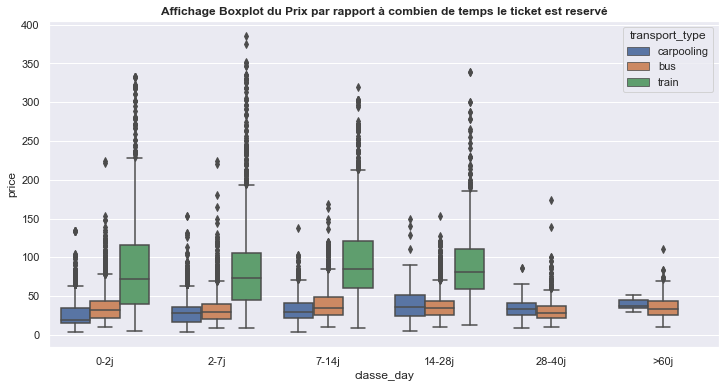

In [845]:
plt.figure(figsize=(12,6))
sns.boxplot('classe_day','price',data=sub_data,hue='transport_type')
plt.title('Affichage Boxplot du Prix par rapport à combien de temps le ticket est reservé',fontweight='bold')
plt.show()

<h2 style="color:green"> Commentaires </h2>

On Remarque que:

- le **co -voiturage** de preference a reserver dans les 2 jours avant le départ (moins cher);

- le **co-voiturage** c'est le meilleur choix pour un trajet à l'improviste .

- par contre le **Bus** a peu pres reste sur le meme prix ;

- pour le **train** c'est  mieux de le reserver 10 jours avant . 

In [846]:
# un boxplot pour les tout les concurennt dans le co-voiturage 

In [712]:
# Calcul du nombre de middle stations , le nombre de concurrent qui proposent le meme trajet
def preprocess_1(row,col):
    """Fonction de relevé du nombre de correspondance ,la concurrence  dans un trajet"""
    

    return row[col].fillna(0).apply(lambda x: len(str(x).split(','))).astype('int64')

In [713]:
ticket_data['nbr_arret']=preprocess_1(ticket_data,'middle_stations')
ticket_data['nbr_arret']

0        1
1        2
2        4
3        4
4        2
        ..
74163    2
74164    2
74165    2
74166    2
74167    2
Name: nbr_arret, Length: 74168, dtype: int64

In [715]:
ticket_data['nbr_concurrence']=preprocess_1(ticket_data,'other_companies')
ticket_data['nbr_concurrence']

0        1
1        1
2        2
3        2
4        1
        ..
74163    1
74164    1
74165    1
74166    1
74167    1
Name: nbr_concurrence, Length: 74168, dtype: int64

In [199]:
ticket_data['month']=ticket_data.departure_ts.apply(lambda x: x.month)
ticket_data['day']=ticket_data.departure_ts.apply(lambda x: x.day)

In [194]:
%matplotlib inline

/Users/xxx/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/xxx/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


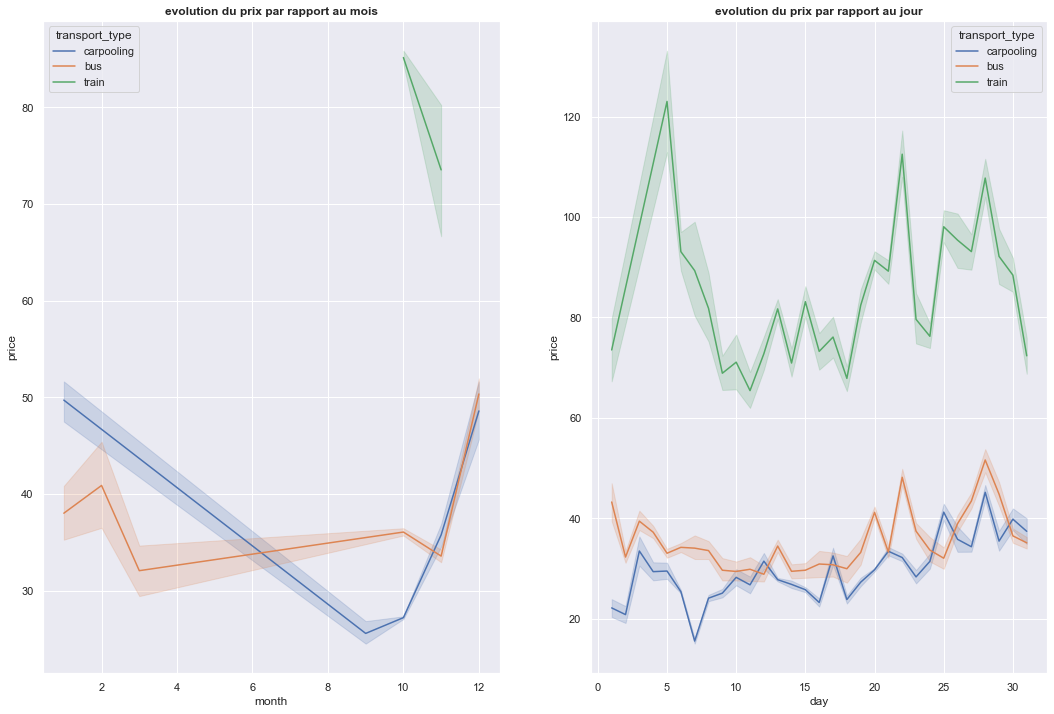

In [211]:
plt.figure(figsize=(18,12))

plt.subplot(1, 2, 1)

sns.lineplot('month','price',data=ticket_data,hue='transport_type')
plt.title('evolution du prix par rapport au mois',fontweight="bold")



plt.subplot(1, 2, 2)
sns.lineplot('day','price',data=ticket_data,hue='transport_type')
plt.title('evolution du prix par rapport au jour',fontweight="bold")
plt.show()



<h4 style="color:green">Commentaires</h4>

On Remarque que:

- le prix augmente dans le mois de decembre (Les vacance de Noel) dans tout les types de transports ;
- Apres le mois du juin le co-voiturage est moins cher que le bus .

In [277]:
# fausse info 

ticket_data[ticket_data['time_before_departure_hours']<0][['departure_ts','search_ts','time_before_departure','time_before_departure_hours']]

,departure_ts,search_ts,time_before_departure,time_before_departure_hours
54,2017-09-15 09:30:00+00:00,2017-10-01 07:19:44.149000+00:00,-16 days +02:10:15.851000,-381.829167
222,2017-09-15 00:00:00+00:00,2017-10-01 07:19:44.148000+00:00,-17 days +16:40:15.852000,-391.329167
223,2017-09-15 07:00:00+00:00,2017-10-01 07:19:44.149000+00:00,-17 days +23:40:15.851000,-384.329167
224,2017-09-15 07:00:00+00:00,2017-10-01 07:19:44.149000+00:00,-17 days +23:40:15.851000,-384.329167
225,2017-09-15 07:40:01+00:00,2017-10-01 07:19:44.149000+00:00,-16 days +00:20:16.851000,-383.662222
...,...,...,...,...
2668,2017-09-08 17:00:00+00:00,2017-10-02 05:40:59.344000+00:00,-24 days +11:19:00.656000,-564.683333
24700,2017-10-06 16:40:00+00:00,2017-10-07 17:23:29.619000+00:00,-2 days +23:16:30.381000,-24.725000
24701,2017-10-06 17:20:00+00:00,2017-10-07 17:23:29.619000+00:00,-2 days +23:56:30.381000,-24.058333
24702,2017-10-06 19:50:00+00:00,2017-10-07 17:23:29.619000+00:00,-1 days +02:26:30.381000,-21.558333


In [281]:

sub_data=ticket_data[ticket_data['time_before_departure_hours']>0]
sub_data.head()

,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,...,classe,fullname,transport_type,time_before_departure,time_before_departure_hours,n_middle_stations,nbr_arret,month,day,temps_reservation
0,8385,NaN,NaN,2017-10-13 14:00:00+00:00,2017-10-13 20:10:00+00:00,4550,2017-10-01 00:13:31.327000+00:00,NaN,NaN,611,...,201-800km,Blablacar,carpooling,12 days 13:46:28.673000,301.774444,1,1,10,13,NaN
1,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{149,418}",{13},611,...,201-800km,Ouibus,bus,12 days 12:51:24.227000,300.856667,2,2,10,13,NaN
2,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{798,798,6794,6246}","{8377,8376}",611,...,201-800km,IntercitÃ©s,train,12 days 13:13:19.788000,301.221944,4,4,10,13,NaN
3,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{798,798,6794,6246}","{8377,8376}",611,...,201-800km,IntercitÃ©s,train,12 days 13:13:19.787000,301.221944,4,4,10,13,NaN
4,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,"{5983,5983}",{8380},611,...,201-800km,IntercitÃ©s de Nuit,train,12 days 21:32:19.787000,309.538611,2,2,10,13,NaN


In [283]:
sub_data.time_before_departure_hours.describe()

count    73910.000000
mean       175.429144
std        252.308237
min          1.959167
25%         47.383681
50%         99.342917
75%        204.408542
max       4233.222778
Name: time_before_departure_hours, dtype: float64

In [459]:
ticket_data.head()

,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,...,transport_type,time_before_departure,time_before_departure_hours,n_middle_stations,nbr_arret,month,day,temps_reservation,temps_reserve,nbr_concurrence
0,8385,NaN,NaN,2017-10-13 14:00:00+00:00,2017-10-13 20:10:00+00:00,4550,2017-10-01 00:13:31.327000+00:00,NaN,NaN,611,...,carpooling,12 days 13:46:28.673000,301.774444,1,1,10,13,NaN,NaN,1
1,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{149,418}",{13},611,...,bus,12 days 12:51:24.227000,300.856667,2,2,10,13,NaN,NaN,1
2,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{798,798,6794,6246}","{8377,8376}",611,...,train,12 days 13:13:19.788000,301.221944,4,4,10,13,NaN,NaN,2
3,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{798,798,6794,6246}","{8377,8376}",611,...,train,12 days 13:13:19.787000,301.221944,4,4,10,13,NaN,NaN,2
4,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,"{5983,5983}",{8380},611,...,train,12 days 21:32:19.787000,309.538611,2,2,10,13,NaN,NaN,1


# Modelling 

In [421]:
features = ['company', 'travel_time_hours', 'distance', 'transport_type', 'time_before_departure_hours', 'nbr_arret','day', 'month', 'nbr_concurrence']
X = ticket_data[ticket_data['time_before_departure_hours']<0][features]
y = ticket_data[ticket_data['time_before_departure_hours']<0].price.values

In [422]:
X

,company,travel_time_hours,distance,transport_type,time_before_departure_hours,nbr_arret,day,month,nbr_concurrence
54,8385,3.500000,309.015572,carpooling,-381.829167,1,15,9,1
222,8385,3.666667,309.015572,carpooling,-391.329167,1,15,9,1
223,8385,3.500000,309.015572,carpooling,-384.329167,1,15,9,1
224,8385,4.166667,309.015572,carpooling,-384.329167,1,15,9,1
225,8385,3.500000,309.015572,carpooling,-383.662222,1,15,9,1
...,...,...,...,...,...,...,...,...,...
2668,8385,6.333333,338.276762,carpooling,-564.683333,1,8,9,1
24700,8385,2.000000,99.887266,carpooling,-24.725000,1,6,10,1
24701,8385,2.000000,99.887266,carpooling,-24.058333,1,6,10,1
24702,8385,1.833333,99.887266,carpooling,-21.558333,1,6,10,1


In [423]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import datetime







from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,cross_val_score,validation_curve

from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost.sklearn import XGBRegressor



from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier,VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingClassifier,VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,StackingRegressor,AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [424]:
def encodage(row):
    encoder=LabelEncoder()

    return encoder.fit_transform(row['transport_type'])
    
    
X.loc[:,'transport_type']=encodage(X)

In [428]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [569]:
# Create the parameter grid for GridSearchCV

'''
param_grid = { 
            "n_estimators"      : [0,500,1000,1500,2000],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8,10],
            "bootstrap": [True, False],
            'max_depth': [80, 90, 100],
            'min_samples_leaf': [1, 3, 4, 5]
}

# Setup grid search

rf_grid = GridSearchCV(estimator =RandomForestRegressor(), param_grid = param_grid, cv=5, n_jobs=1, verbose=1)

# Fit the grid search model on training dataset
rf_grid.fit(X_train, y_train)

'''



'\nparam_grid = { \n            "n_estimators"      : [0,500,1000,1500,2000],\n            "max_features"      : ["auto", "sqrt", "log2"],\n            "min_samples_split" : [2,4,8,10],\n            "bootstrap": [True, False],\n            \'max_depth\': [80, 90, 100],\n            \'min_samples_leaf\': [1, 3, 4, 5]\n}\n\n# Setup grid search\nrf_grid = GridSearchCV(estimator =RandomForestRegressor(), param_grid = param_grid, cv=5, n_jobs=1, verbose=1)\n\n# Fit the grid search model on training dataset\nrf_grid.fit(X_train, y_train)\n\n'

In [570]:
print(rf_grid.best_params_)

{'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 500}


In [571]:
# Get best RF estimator based on best parameters, and use RF regressor to predict on test set
rf_best = rf_grid.best_estimator_
y_pred_test = rf_best.predict(X_test)




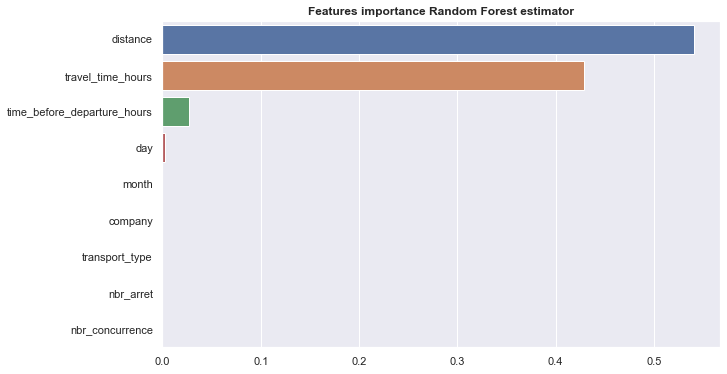

In [620]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title('Features importance Random Forest estimator',fontweight='bold')
plt.show()

In [627]:
def pourcentage_erreur(y_test,y_pred):
    error=np.abs((y_test-y_pred)/y_test)# savoir le poutencage d'erreur entre le y_test,y_pred
    return np.mean(error)

In [629]:
pourcentage_erreur(y_test,rf_best.predict(X_test)) 

0.07340912294533146

<h3 style="color:red">Commentaires</h3>

- **Sur les résultats:**
    - 0.07 explique que par exemple si on a la valeur reel est de 25€ alors la valeur predite et 23€ donc une difference de 2€ 

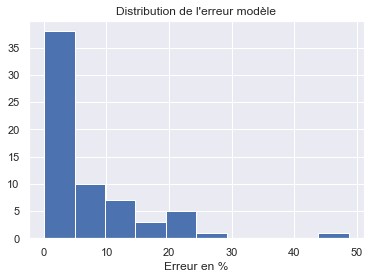

In [633]:
RMSE=pd.DataFrame((np.abs(y_test-rf_best.predict(X_test))/y_test))*100
RMSE[RMSE<150].hist(bins=10)
plt.xlabel('Erreur en %')
plt.title('Distribution de l\'erreur modèle')
plt.show()

In [577]:
print("RMSE = {}".format(mean_squared_error(y_test, y_pred_test, squared=False)))
print("MAE = {}".format(mean_absolute_error(y_test, y_pred_test)))

RMSE = 5.401294634836755
MAE = 2.2311983997445237


- L'erreur **RMSE** est d'environ **5€**, la **MAE** d'environ **2 €**

## LassoCV :

In [540]:
params={
    
    
    
    'copy_X' :[True, False],
    'fit_intercept':[True, False],
    'max_iter':[0,50,100,150,200],
    'normalize':[True, False],
     'verbose':[True, False] 
}



grid = GridSearchCV(LassoCV(), params, n_jobs=-1, cv=5)

grid.fit(X_train,y_train)

grid.best_params_


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


{'copy_X': True,
 'fit_intercept': True,
 'max_iter': 50,
 'normalize': False,
 'verbose': True}

In [584]:
model = LassoCV(copy_X =True,
 fit_intercept=True,
 max_iter=50,
 normalize=False,
 verbose=True)
model.fit(X_train,y_train)

87.9604642979161


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [587]:
y_pred=model.predict(X_test)

In [589]:
def pourcentage_erreur(y_test,y_pred):
    error=np.abs((y_test-y_pred)/y_test)# savoir le poutencage d'erreur entre le y_test,y_pred
    return np.mean(error)

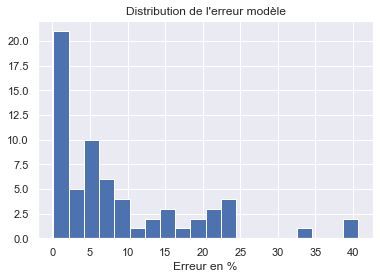

In [621]:
# Calculate performance metrics

rf_dict = { 
          
          'Model':'Lasso CV',
          'MAE':mean_absolute_error(y_test, y_pred),
          'RMSE':np.sqrt(mean_squared_error(y_test, y_pred))
          }


In [622]:
rf_dict

{'Model': 'Lasso CV', 'MAE': 2.083925925878771, 'RMSE': 3.111011154479109}

# <em>
   
- L'erreur **RMSE** est d'environ **3 €**, la **MAE** d'environ **2 €**.Ces valeurs semblent plutôt bonnes en première approximation
</em>